In [56]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import sqlite3
import pandas as pd
import numpy as np

In [57]:
# Connect to the database
conn = sqlite3.connect('random_data_jan.db')

# Load the data
query = "SELECT * FROM sales_data"
df = pd.read_sql(query, conn)

# Convert Billing_Date to datetime
df['Billing_Date'] = pd.to_datetime(df['Billing_Date'])

In [58]:
# Filter only January months from all years
df_jan = df[df['Billing_Date'].dt.month == 1]

# Group by date and product details
grouped = df_jan.groupby(['Product_Brand', 'Brand_Flavour', 'Billing_Date'])['Sum_of_Billed_Quantity'].sum().reset_index()


In [59]:
class SalesDataset(Dataset):
    def __init__(self, series, window_size):
        self.series = series
        self.window_size = window_size

    def __len__(self):
        return len(self.series) - self.window_size

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size]
        y = self.series[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


In [61]:
class SalesLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only last time step output
        return out


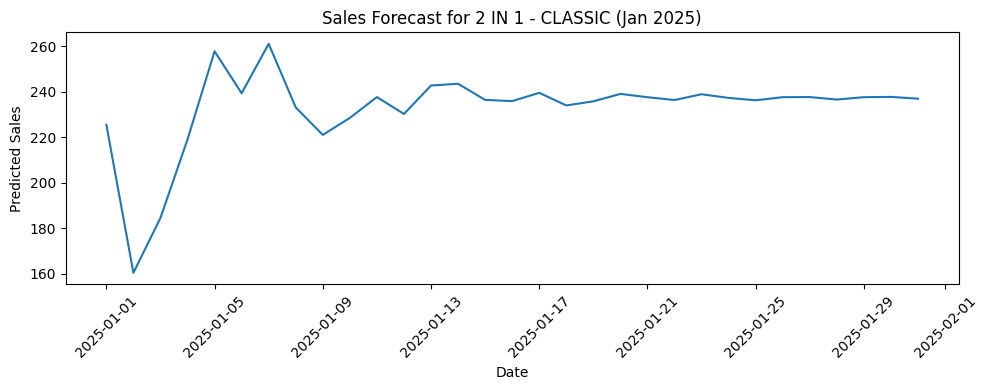

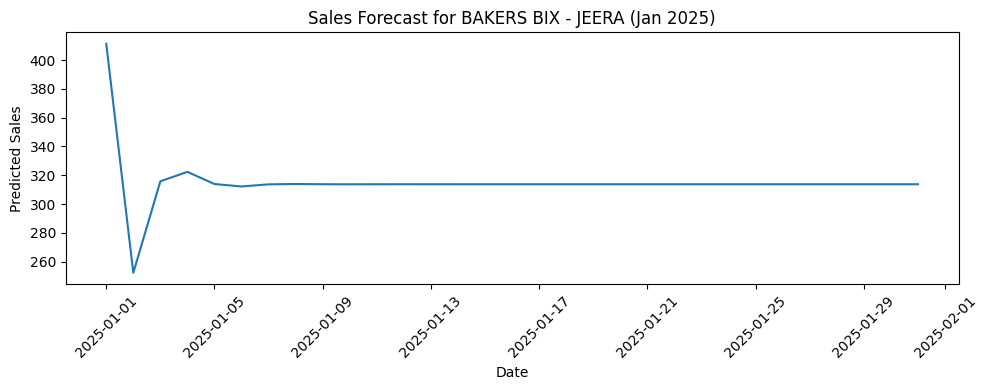

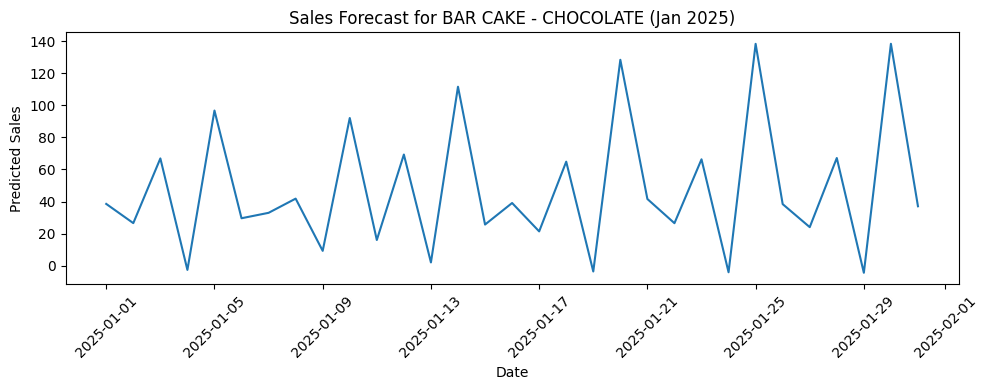

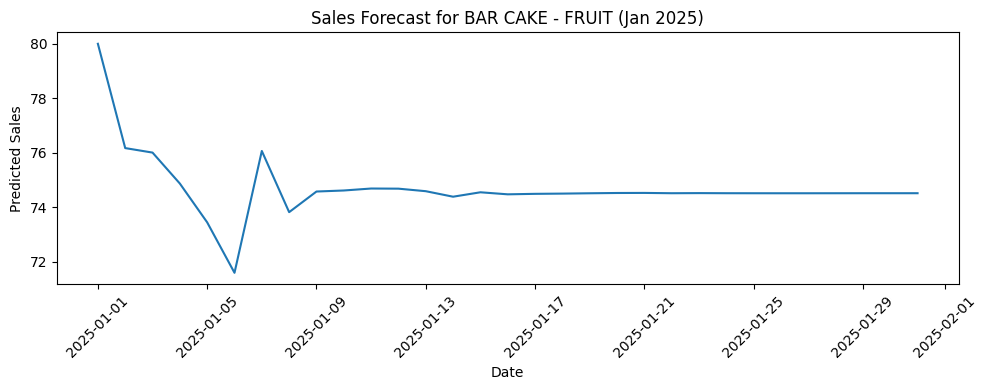

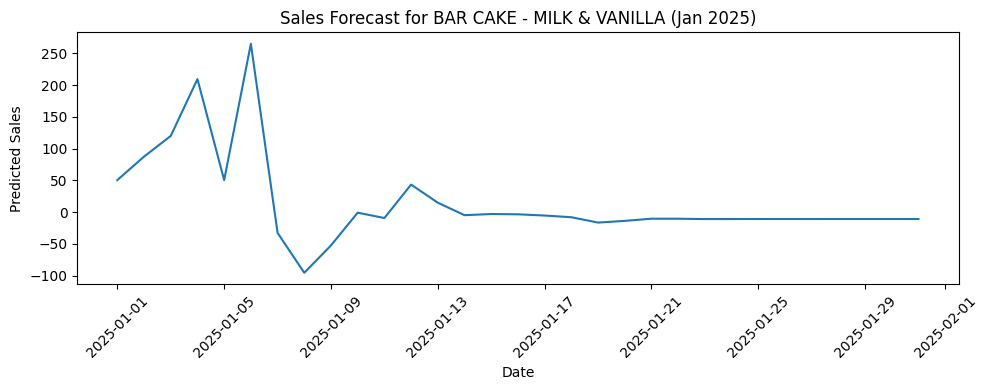

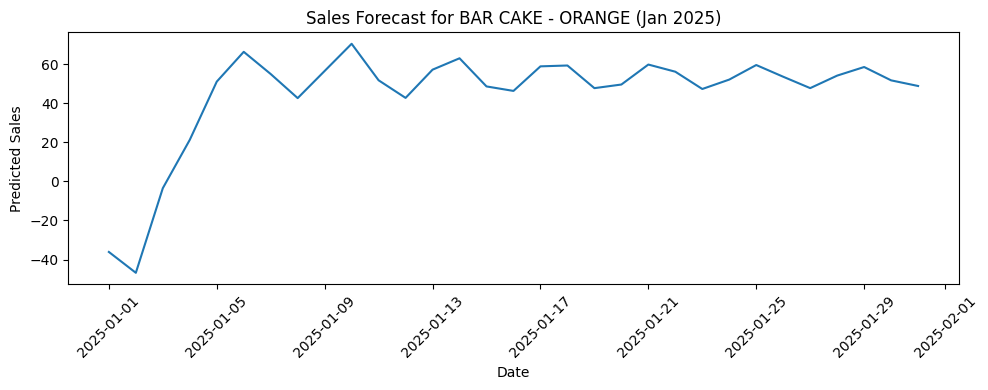

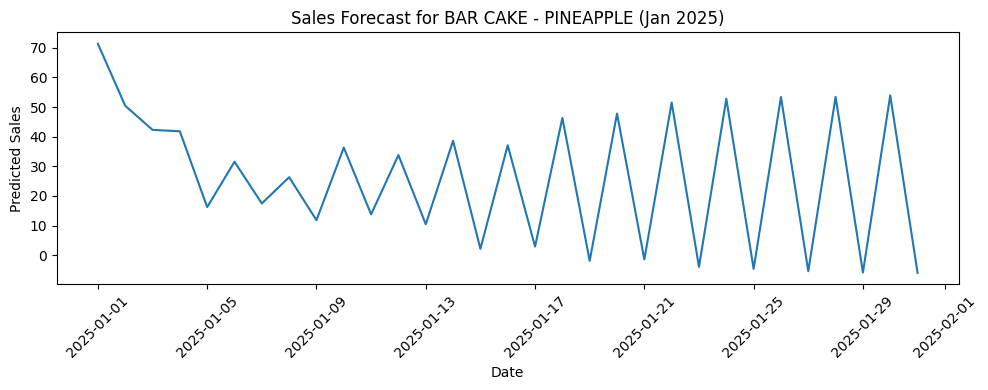

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


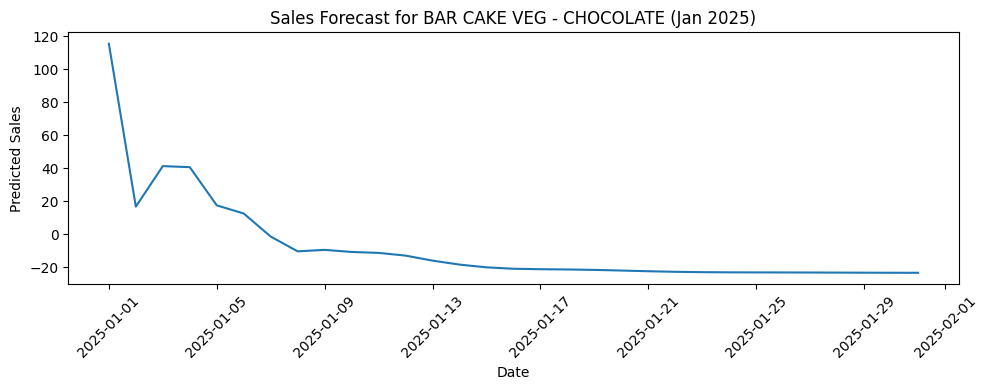

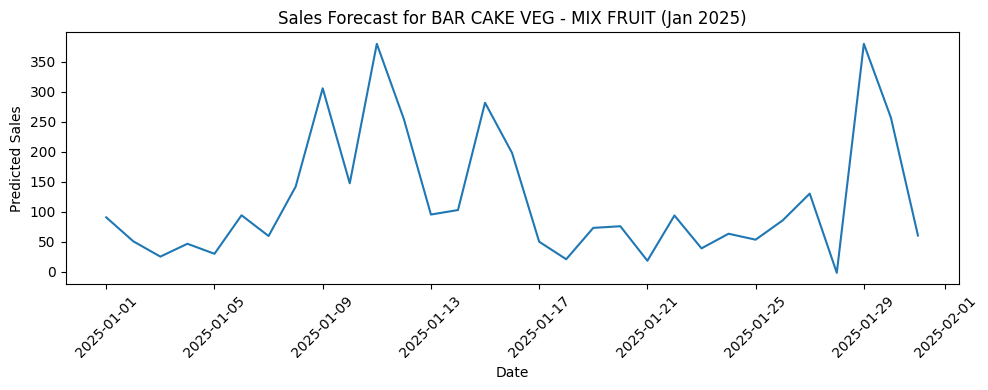

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


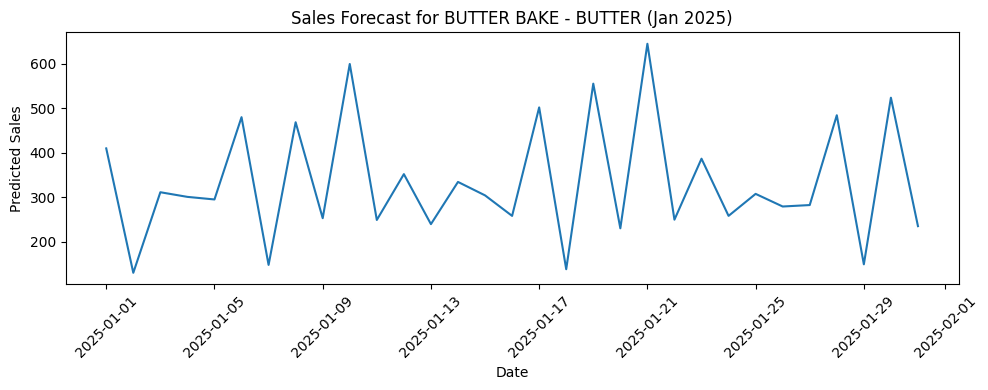

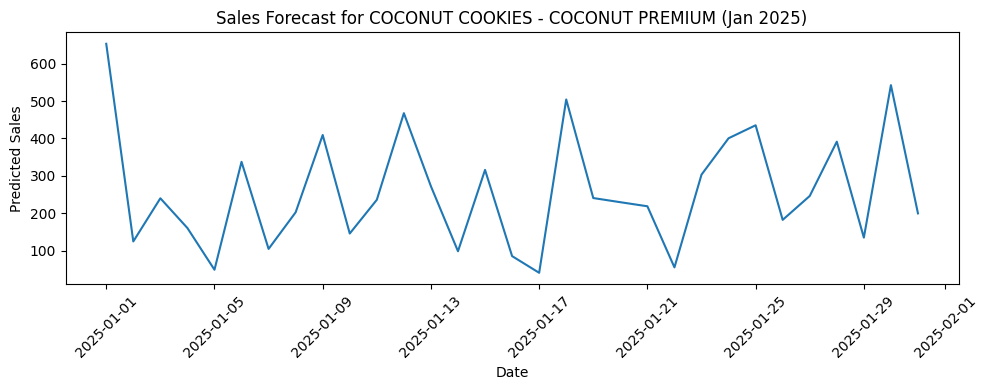

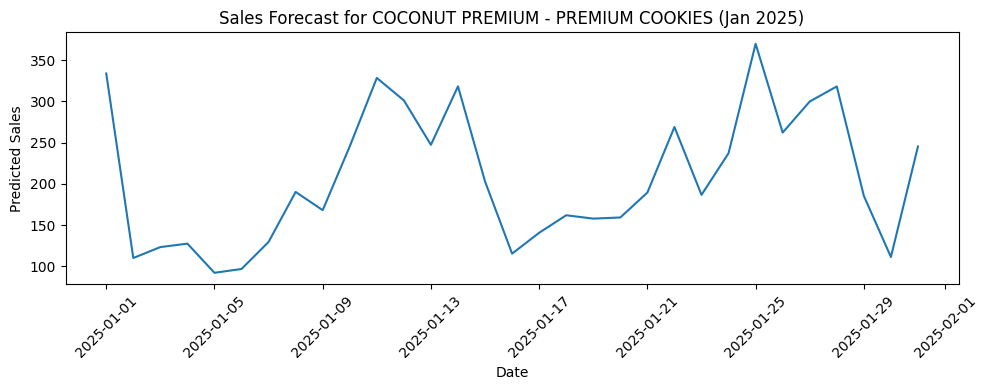

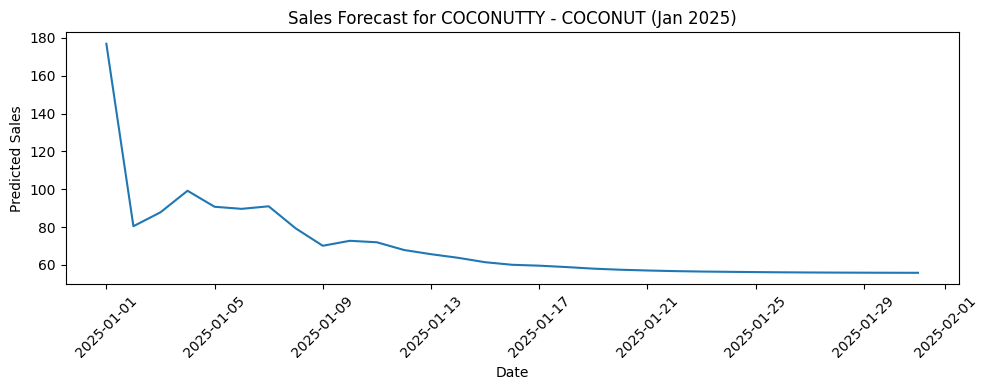

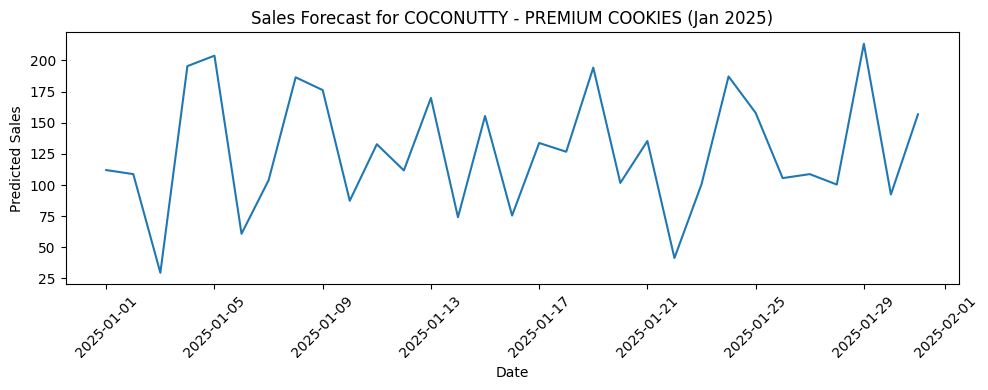

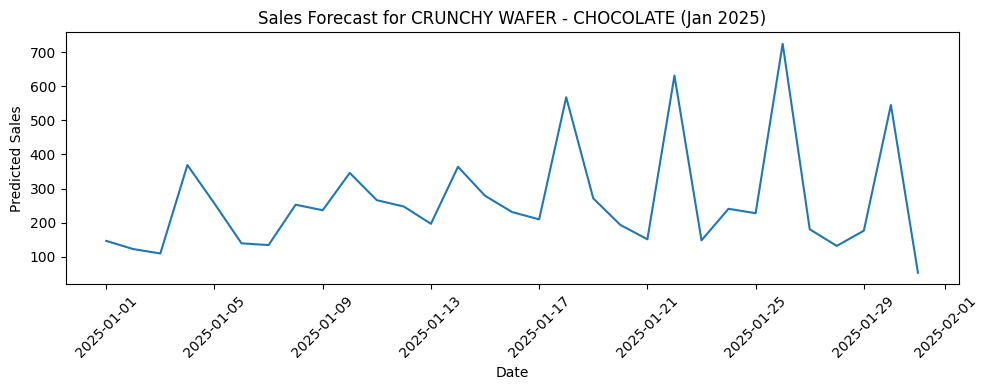

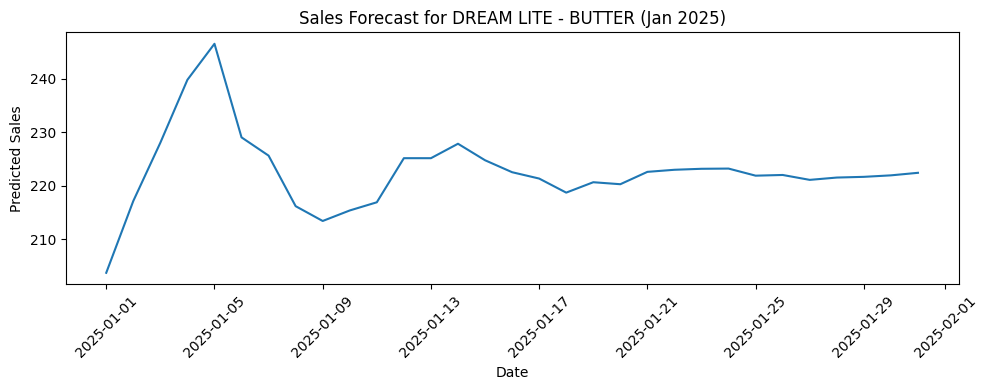

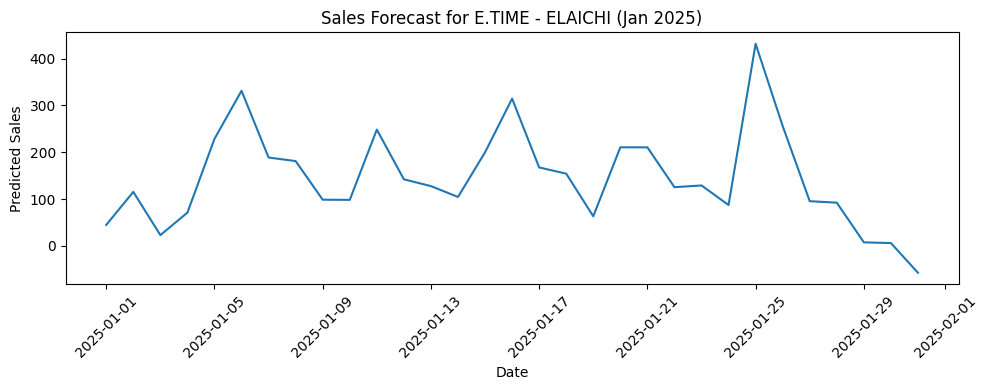

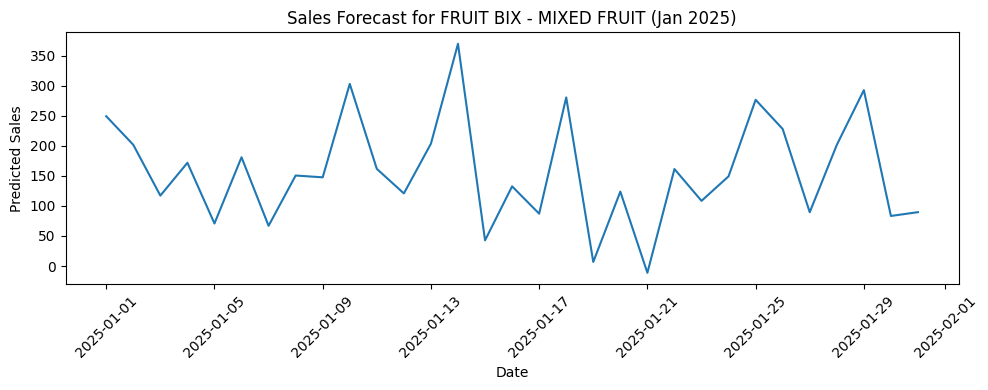

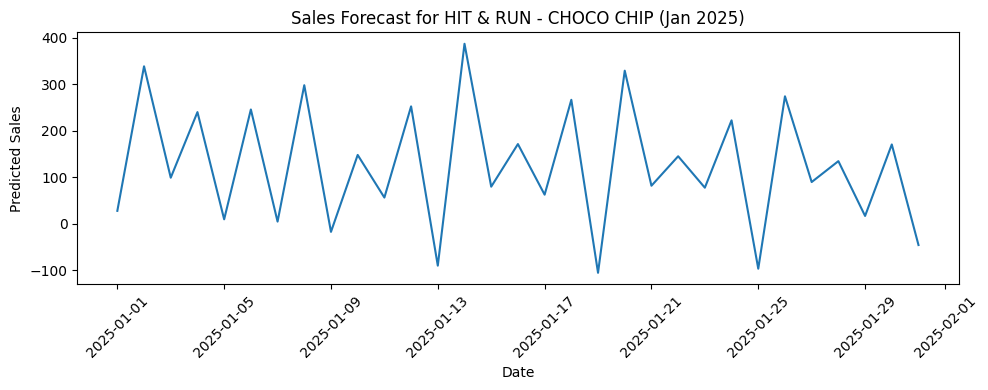

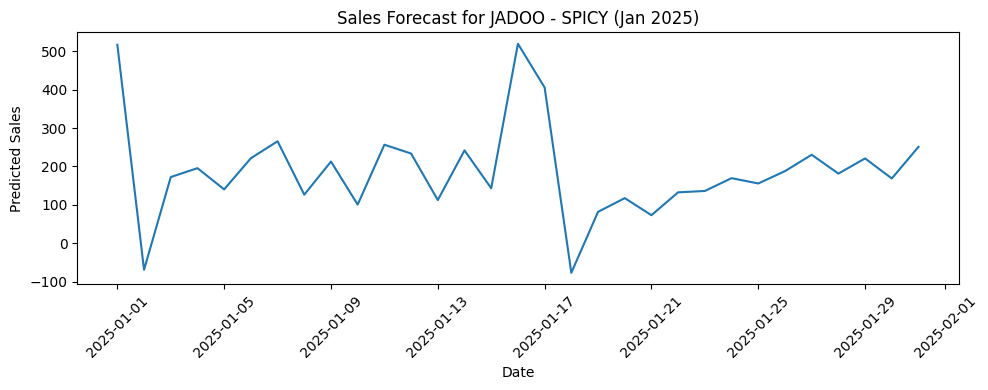

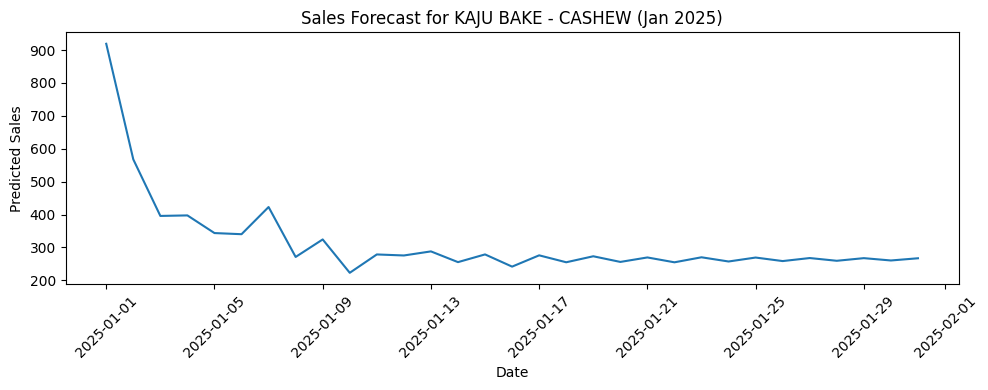

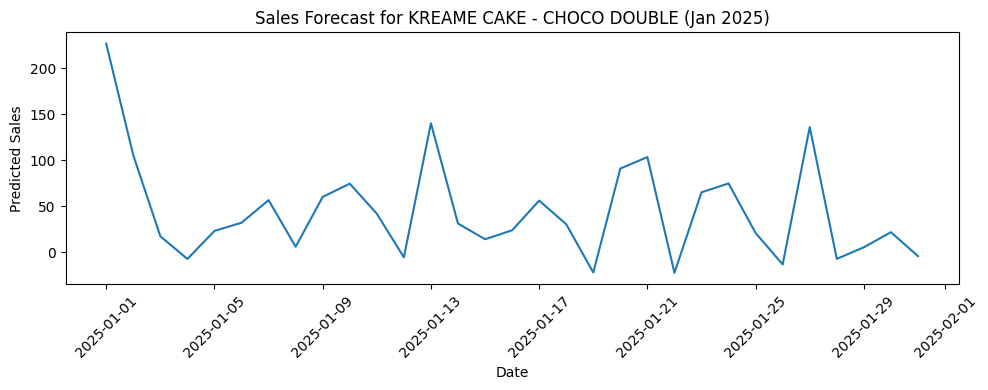

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


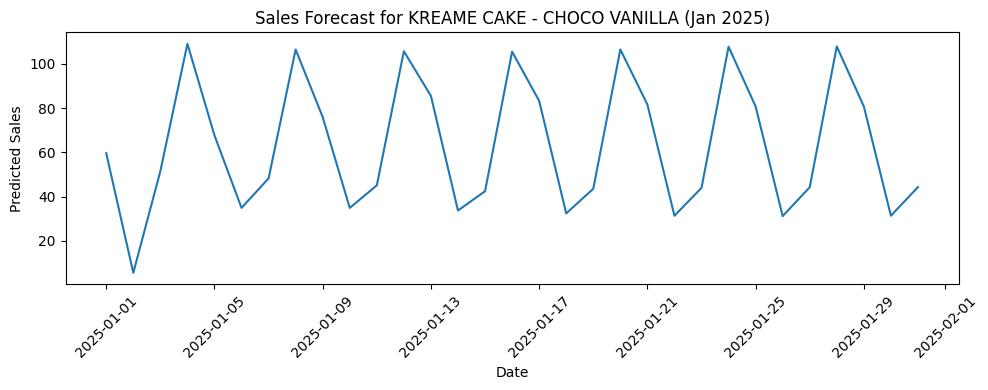

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


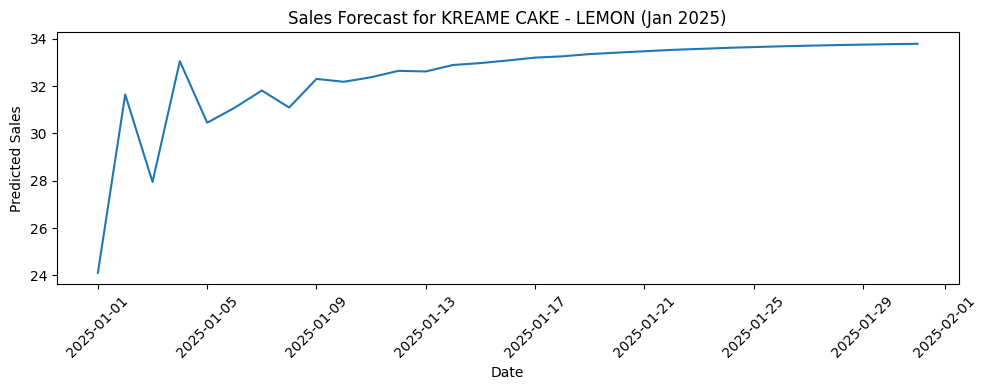

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


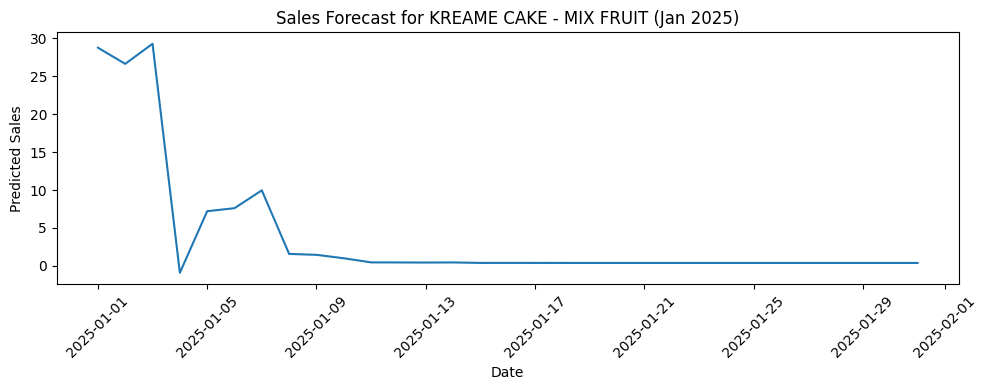

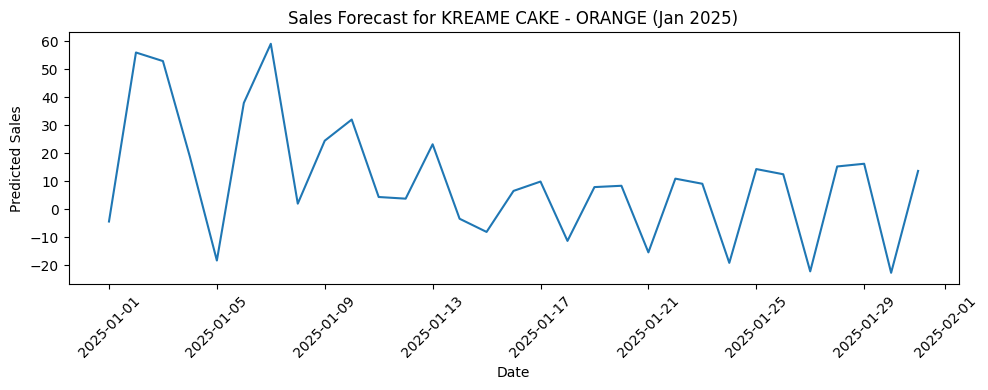

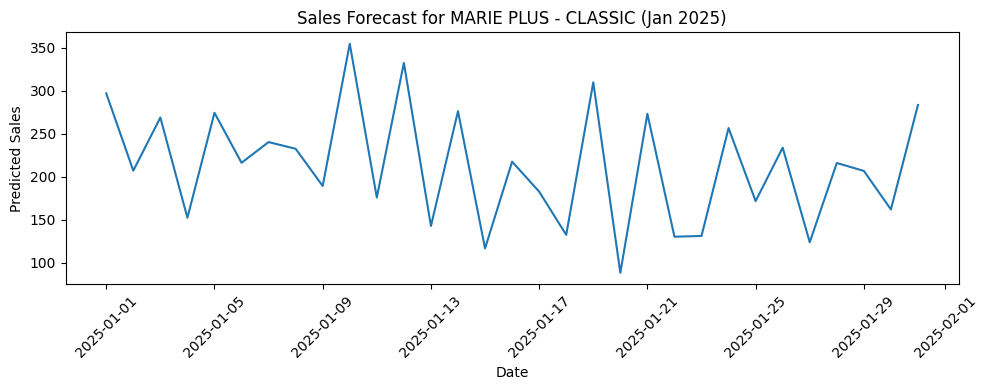

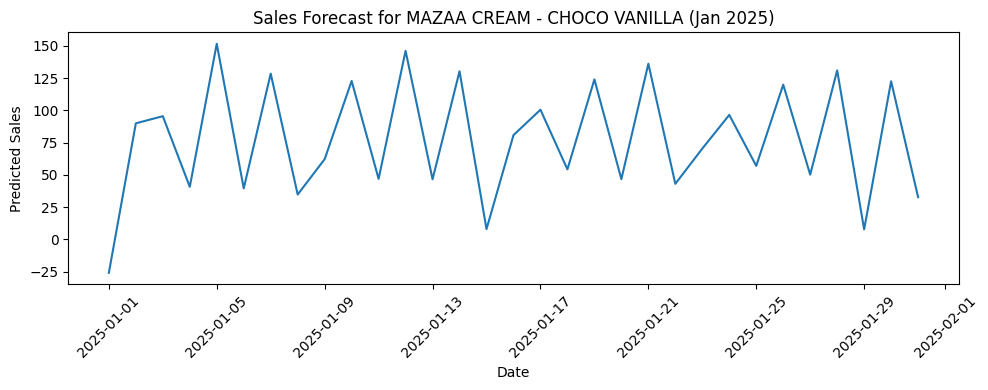

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


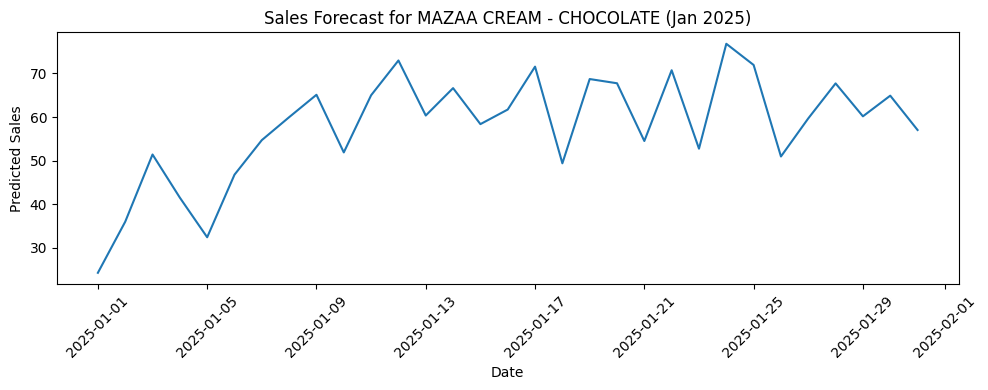

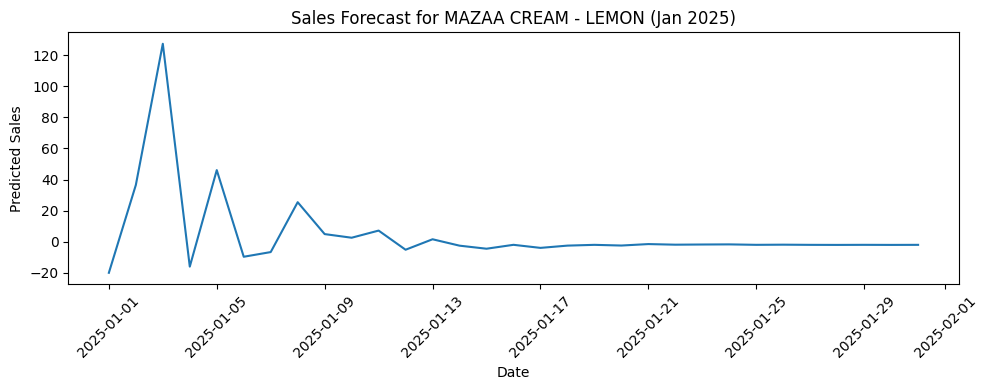

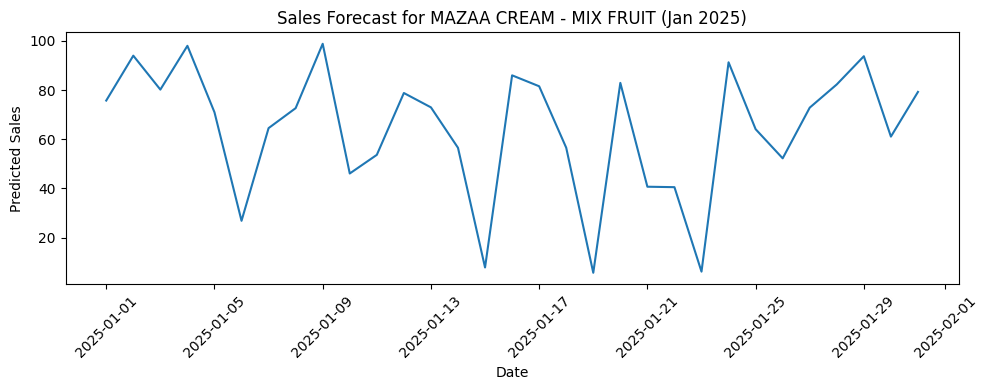

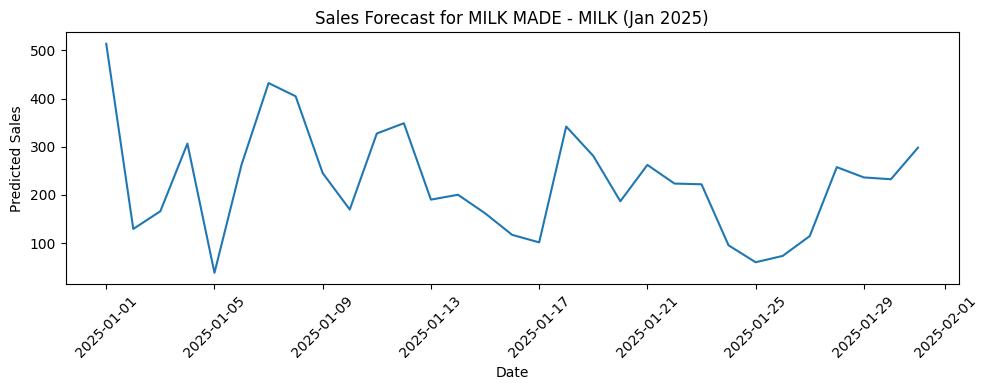

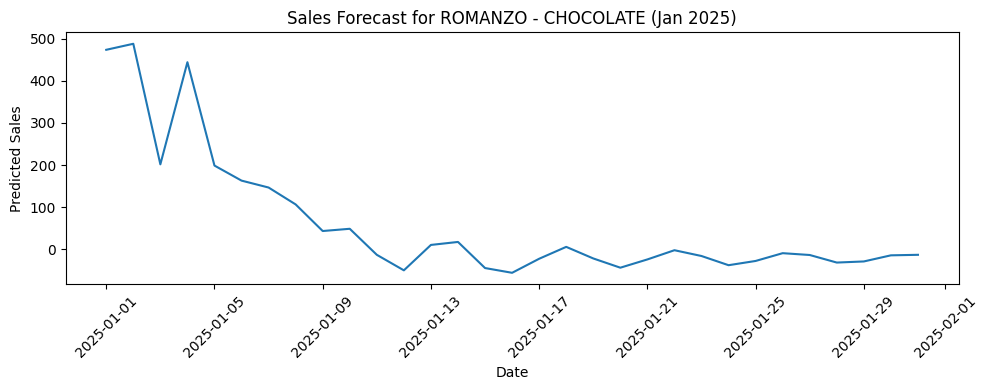

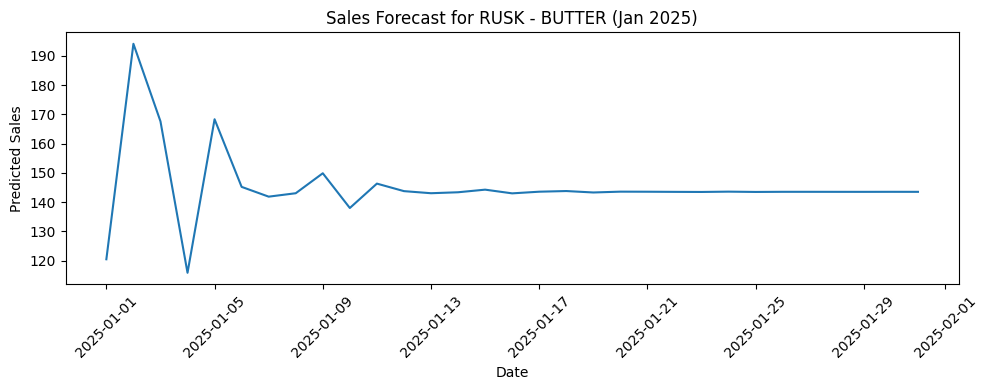

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


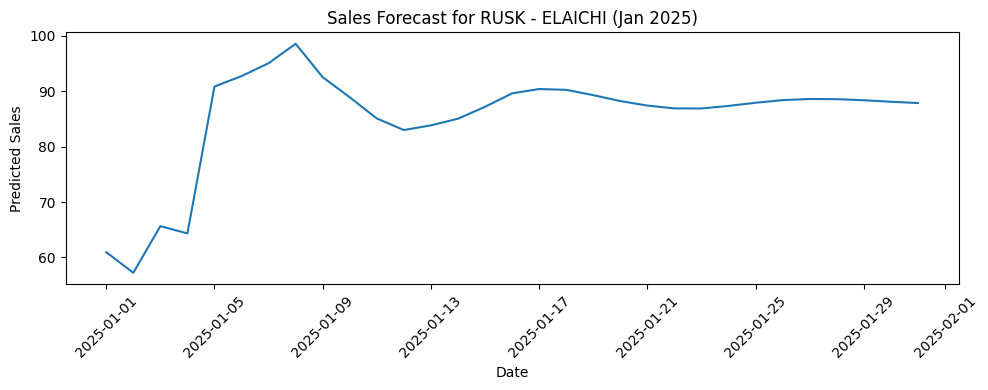

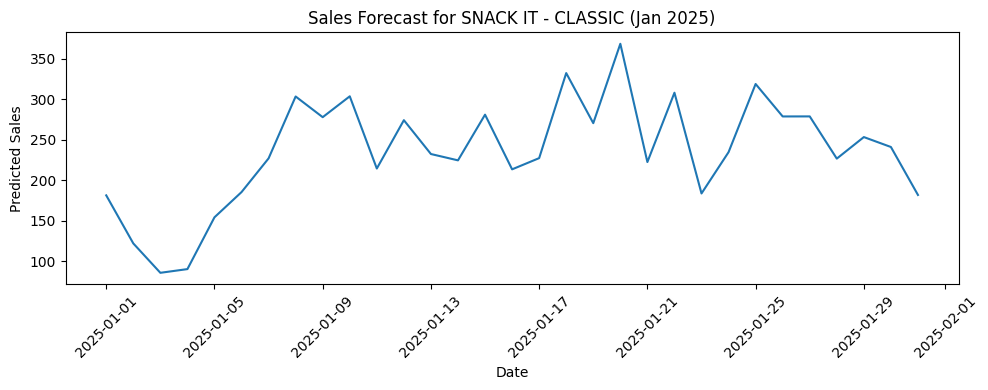

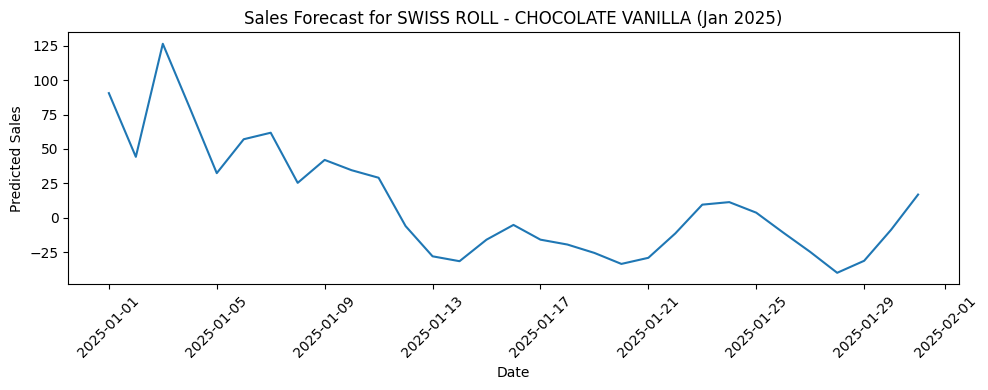

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


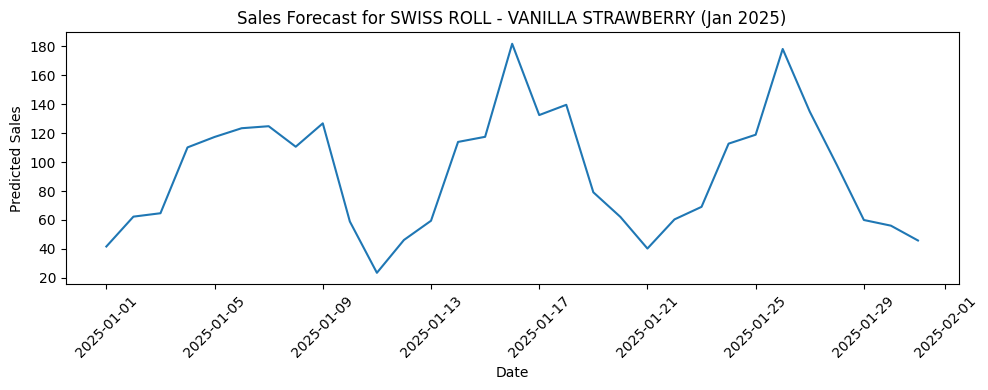

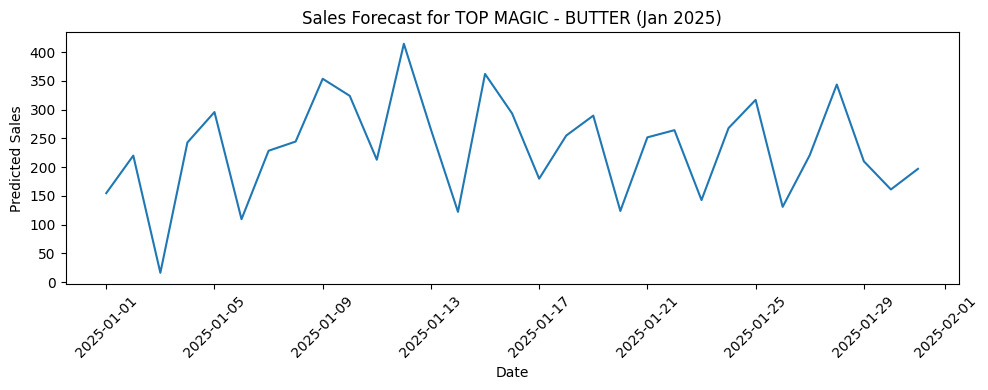

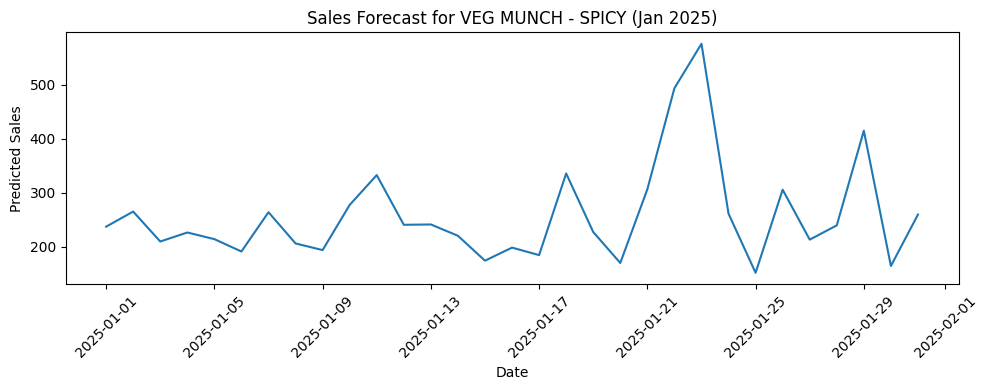

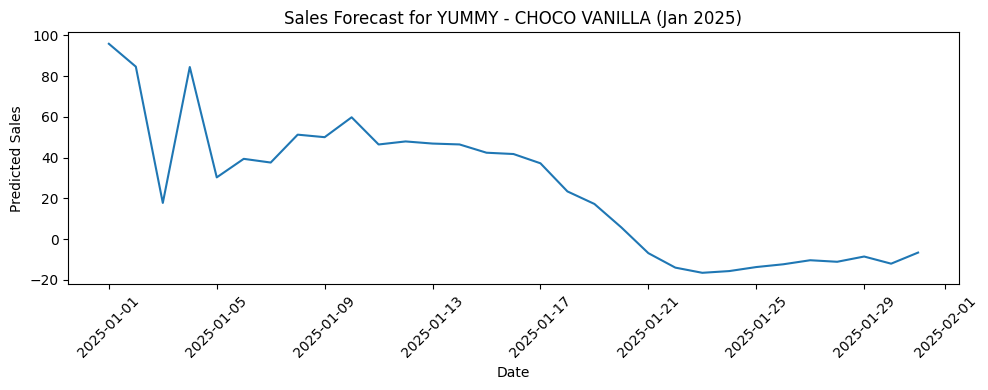

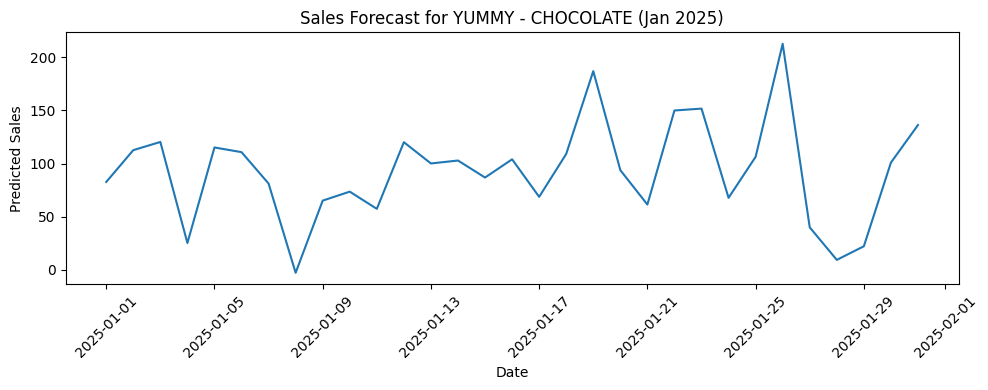

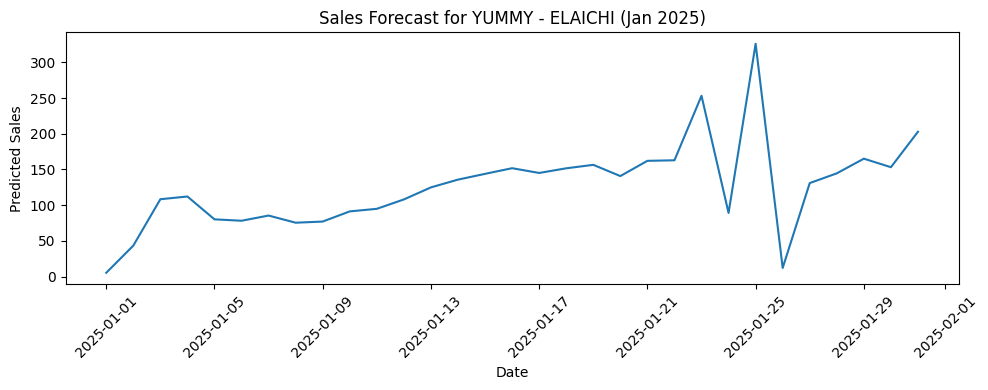

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


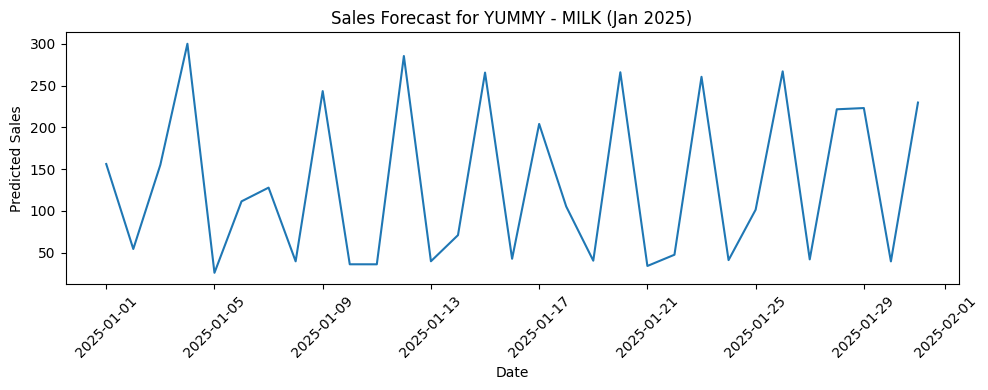

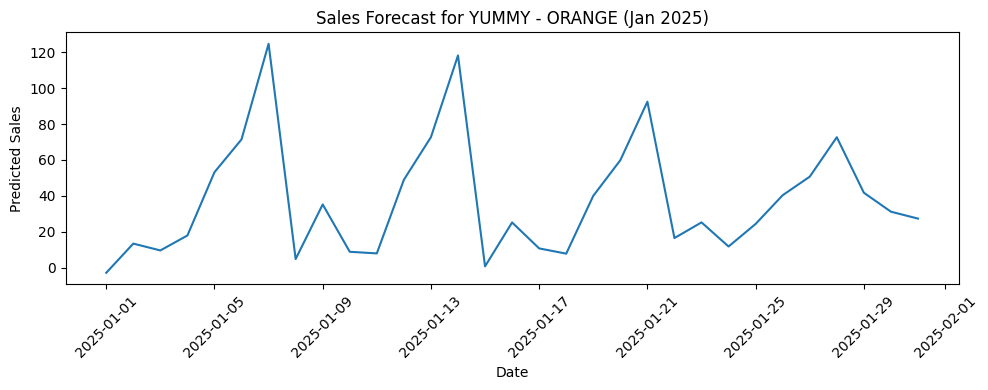

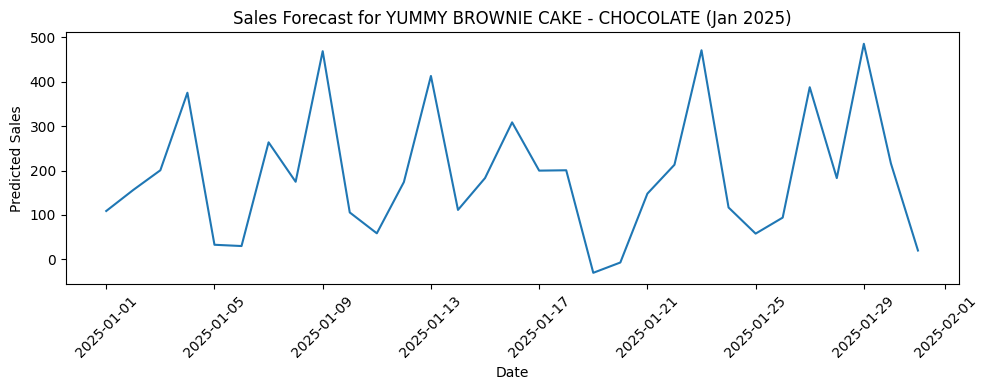

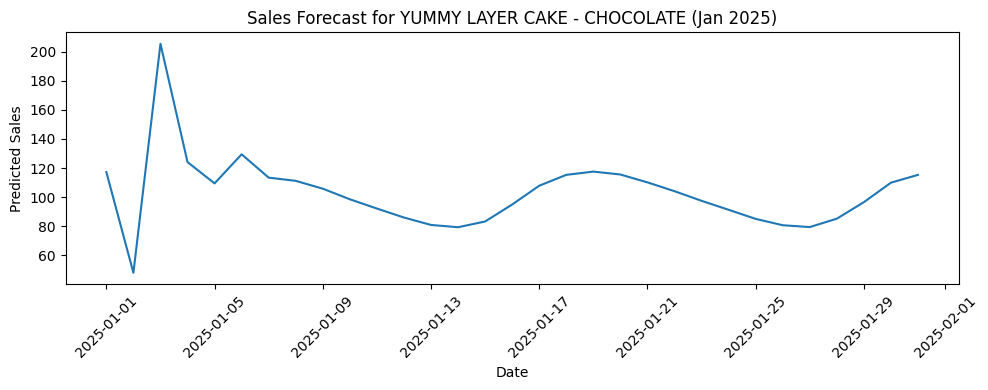

c:\Users\gaura\Desktop\ML\Anmol\env_anmol\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


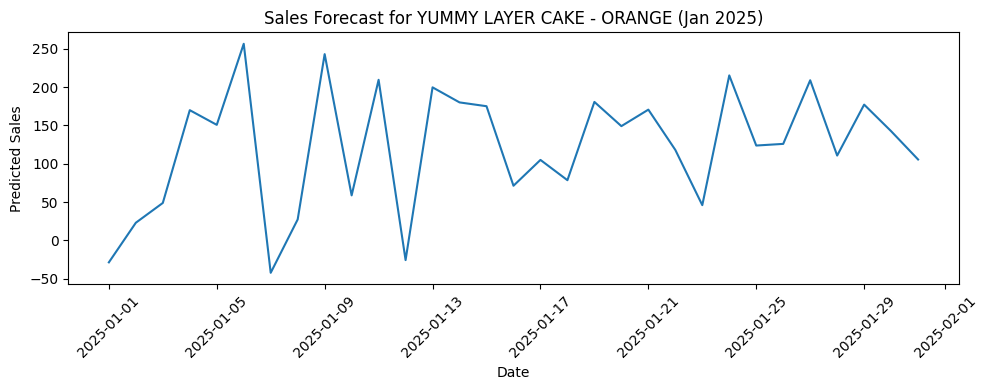

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Get unique brand and flavour combinations
brand_flavour_map = {
    brand: list(group['Brand_Flavour'].unique())
    for brand, group in grouped.groupby('Product_Brand')
}

# Create widgets
brand_dropdown = widgets.Dropdown(
    options=list(brand_flavour_map.keys()),
    description='Brand:'
)

flavour_dropdown = widgets.Dropdown(
    description='Flavour:'
)

# Update flavours when brand changes
def update_flavour_options(*args):
    flavour_dropdown.options = brand_flavour_map[brand_dropdown.value]

brand_dropdown.observe(update_flavour_options, names='value')
update_flavour_options()  # initialize once

# Plot function
def plot_forecast(brand, flavour):
    group = grouped[
        (grouped['Product_Brand'] == brand) &
        (grouped['Brand_Flavour'] == flavour)
    ]
    
    ts = group.set_index('Billing_Date').asfreq('D').fillna(0)['Sum_of_Billed_Quantity']
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1)).flatten()

    dataset = SalesDataset(ts_scaled, window_size=7)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    model = SalesLSTM()
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train
    model.train()
    for epoch in range(100):
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.unsqueeze(-1).to(device)
            y_batch = y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output.squeeze(), y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Forecast
    model.eval()
    input_seq = torch.tensor(ts_scaled[-7:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    preds = []
    for _ in range(31):
        with torch.no_grad():
            pred = model(input_seq)
            preds.append(pred.item())
            new_input = pred.unsqueeze(-1)
            input_seq = torch.cat([input_seq[:, 1:, :], new_input], dim=1)

    pred_rescaled = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    # Plot
    clear_output(wait=True)
    display(brand_dropdown, flavour_dropdown)

    plt.figure(figsize=(12, 5))
    for year in [2021, 2022, 2023, 2024]:
        jan_data = group[
            (group['Billing_Date'] >= pd.Timestamp(f'{year}-01-01')) &
            (group['Billing_Date'] <= pd.Timestamp(f'{year}-01-31'))
        ].set_index('Billing_Date').asfreq('D').fillna(0)['Sum_of_Billed_Quantity']
        plt.plot(jan_data.index, jan_data.values, label=f'{year} Actual')

    future_dates = pd.date_range('2025-01-01', '2025-01-31')
    plt.plot(future_dates, pred_rescaled, label='2025 Prediction', linestyle='--', color='black')

    plt.title(f'Sales Forecast for {brand} - {flavour} (Jan 2021–2025)')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Attach callback
def on_change(change):
    plot_forecast(brand_dropdown.value, flavour_dropdown.value)

brand_dropdown.observe(lambda change: plot_forecast(brand_dropdown.value, flavour_dropdown.value), names='value')
flavour_dropdown.observe(on_change, names='value')

# Initial display
display(brand_dropdown, flavour_dropdown)
plot_forecast(brand_dropdown.value, flavour_dropdown.value)
